In [ ]:
!git clone https://github.com/mdeff/fma.git

In [ ]:
#!:bash
#pragma dataset init fma_small --size 20Gb
set -e

cd /home/jupyter/mnt/datasets/fma_small

wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip -P ./
echo "f0df49ffe5f2a6008d7dc83c6915b31835dfe733  ./fma_metadata.zip" | sha1sum -c -
7z x ./fma_metadata.zip -o./
rm -rf fma_metadata.zip

wget https://os.unil.cloud.switch.ch/fma/fma_small.zip -P ./
echo "ade154f733639d52e35e32f5593efe5be76c6d70  ./fma_small.zip" | sha1sum -c -
7z x ./fma_small.zip -o./
rm -rf fma_small.zip

In [ ]:
#!:bash
#pragma dataset init fma_medium --size 50Gb
set -e

cd /home/jupyter/mnt/datasets/fma_medium

wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip -P ./
echo "f0df49ffe5f2a6008d7dc83c6915b31835dfe733  ./fma_metadata.zip" | sha1sum -c -
7z x ./fma_metadata.zip -o./
rm -rf fma_metadata.zip

wget https://os.unil.cloud.switch.ch/fma/fma_medium.zip -P ./
echo "c67b69ea232021025fca9231fc1c7c1a063ab50b  fma_medium.zip"   | sha1sum -c -
7z x ./fma_medium.zip -o./
rm -rf fma_medium.zip

In [ ]:
%pip install python-dotenv kapre seaborn

In [7]:
#!g2.mig

import importlib
import utils
importlib.reload(utils)

from utils import *


In [ ]:
calculate_x_and_y_from_files()

In [17]:
#pragma dataset delete xy

Unmounting dataset xy... ok
Deleting old dataset xy... ok


In [ ]:
#!:bash
#pragma dataset init xy2 --size 1Gb
cp ./x.npz /home/jupyter/mnt/datasets/xy2/x.npz
cp ./y.npz /home/jupyter/mnt/datasets/xy2/y.npz

In [15]:
#!g2.mig
# run_proc(save_x_stft)

In [19]:
#pragma dataset delete x_stft

Execute error: Dataset x_stft delete requested, but dataset does not exists.


In [ ]:
#!:bash
#pragma dataset init x_stft --size 3Gb
cp ./x_stft.npy /home/jupyter/mnt/datasets/x_stft/x_stft.npy

In [195]:
#!g2.mig
load_x_stft().shape

(7994, 1025, 41)

In [ ]:
#!g2.mig
from tensorflow.keras.backend import clear_session
clear_session()
# ! nvidia-smi

In [ ]:
#!g2.mig
!nvidia-smi

In [8]:
#!g2.mig

# returns (fft_bins_count, bands_count)
@inject("tf")
def get_bands_matrix(fft_bins_count, bands_count):
    sample_rate = 4096
    lower_edge_hertz = 80
    upper_edge_hertz = sample_rate // 2
    matrix = tf.signal.linear_to_mel_weight_matrix(
        bands_count, fft_bins_count, sample_rate, lower_edge_hertz,
        upper_edge_hertz).numpy()
    matrix[:, 0][:np.argmax(matrix[:, 0])] = 1
    matrix[:, -1][np.argmax(matrix[:, -1]):] = 1
    return matrix

# takes (N, stft_bins, time)
# returns (N, bands_count, time)
@inject("plt")
def stft_to_bands(mag, bands_count):
    fft_bins_count = mag.shape[1]
    matrix = get_bands_matrix(fft_bins_count, bands_count)
    res = np.einsum('ijk,jf->ifk', mag, matrix)
    return res
    

# bands     (N, bands_count, time)
# eq_coeffs (N, bands_count)
# returns   (N, bands_count, time)
def apply_eq_to_bands(bands, eq_coefs):
    return bands * eq_coefs[..., np.newaxis]


# mag     (N, fft_bins, time)
# eq_coeffs (N, bands_count)
# returns   (N, fft_bins, time)
def apply_eq_to_stft(mag, eq_coeffs):
    N = mag.shape[0]
    fft_bins_count = mag.shape[1]
    bands_count = eq_coeffs.shape[1]
    matrix = get_bands_matrix(fft_bins_count, bands_count)  # (fft_bins_count, bands_count)
    new_eq_coeffs = np.einsum("fb,nb->nf", matrix, eq_coeffs) # (N, fft_bins_count)
    res = apply_eq_to_bands(mag, new_eq_coeffs)
    return res


#!g2.mig

@inject("x_stft", log=True)
def calc_bands(bands_count):
    mag, ang = nnorm(x_stft)
    bands = stft_to_bands(mag, bands_count)
    bands /= 62
    np.save("bands", bands)

@register("bands")
def load_bands():
    return np.load("bands.npy")

# calc_bands(10)

In [79]:
#!g2.mig


In [77]:
#!g2.mig
#     def tf_random_sample(array, count):
#         idxs = tf.range(tf.shape(array)[0])
#         ridxs = tf.random.shuffle(idxs)[:count]
#         rinput = tf.gather(inputs, ridxs)
#         return rinput

<module 'numpy' from '/kernel/fallback/lib/python3.8/site-packages/numpy/__init__.py'>

In [3]:
#!g2.mig
np.min(load_bands()), np.max(load_bands())

(0.0, 0.98855895)

In [37]:
#!g2.mig
len(load_bands())

7994

starting proc
loading bands
loading keras
loading tf
loading plt


2022-09-18 17:53:43.348944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 17:53:43.866674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0


Epoch 1/3000


2022-09-18 17:53:44.688229: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 - 1s - g_loss: 0.7136 - d_loss: 1.3850 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0436
Epoch 2/3000
1/1 - 0s - g_loss: 0.7091 - d_loss: 1.3830 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0442
Epoch 3/3000
1/1 - 0s - g_loss: 0.7035 - d_loss: 1.3819 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0449
Epoch 4/3000
1/1 - 0s - g_loss: 0.6993 - d_loss: 1.3810 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0456
Epoch 5/3000
1/1 - 0s - g_loss: 0.6965 - d_loss: 1.3802 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0463
Epoch 6/3000
1/1 - 0s - g_loss: 0.6955 - d_loss: 1.3793 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0470
Epoch 7/3000
1/1 - 0s - g_loss: 0.6965 - d_loss: 1.3782 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0478
Epoch 8/3000
1/1 - 0s - g_loss: 0.6992 - d_loss: 1.3771 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.04

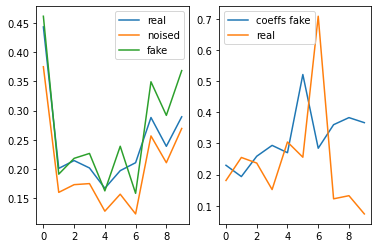

1/1 - 0s - g_loss: 0.7434 - d_loss: 1.3301 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0837
Epoch 52/3000
1/1 - 0s - g_loss: 0.7658 - d_loss: 1.3299 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0844
Epoch 53/3000
1/1 - 0s - g_loss: 0.7541 - d_loss: 1.3320 - diff_with_real: 3.7533e-04 - noise: 3.8784e-04 - g_diversity: 0.0849
Epoch 54/3000
1/1 - 0s - g_loss: 0.7699 - d_loss: 1.3345 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0855
Epoch 55/3000
1/1 - 0s - g_loss: 0.7525 - d_loss: 1.3391 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0859
Epoch 56/3000
1/1 - 0s - g_loss: 0.7548 - d_loss: 1.3394 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0861
Epoch 57/3000
1/1 - 0s - g_loss: 0.7405 - d_loss: 1.3473 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0862
Epoch 58/3000
1/1 - 0s - g_loss: 0.7325 - d_loss: 1.3477 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversit

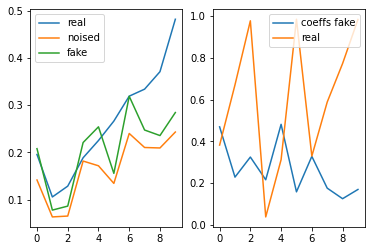

1/1 - 0s - g_loss: 0.7805 - d_loss: 1.2737 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0989
Epoch 102/3000
1/1 - 0s - g_loss: 0.7603 - d_loss: 1.2693 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0994
Epoch 103/3000
1/1 - 0s - g_loss: 0.7916 - d_loss: 1.2605 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0998
Epoch 104/3000
1/1 - 0s - g_loss: 0.7822 - d_loss: 1.2554 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1001
Epoch 105/3000
1/1 - 0s - g_loss: 0.7818 - d_loss: 1.2515 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1004
Epoch 106/3000
1/1 - 0s - g_loss: 0.8073 - d_loss: 1.2436 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1006
Epoch 107/3000
1/1 - 0s - g_loss: 0.7984 - d_loss: 1.2412 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1008
Epoch 108/3000
1/1 - 0s - g_loss: 0.8033 - d_loss: 1.2345 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

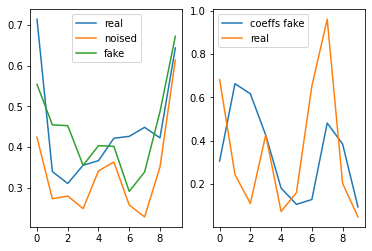

1/1 - 0s - g_loss: 1.2576 - d_loss: 0.8704 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1615
Epoch 152/3000
1/1 - 0s - g_loss: 1.3848 - d_loss: 0.8558 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1607
Epoch 153/3000
1/1 - 0s - g_loss: 1.3180 - d_loss: 0.8498 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1595
Epoch 154/3000
1/1 - 0s - g_loss: 1.3889 - d_loss: 0.8385 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1579
Epoch 155/3000
1/1 - 0s - g_loss: 1.3909 - d_loss: 0.8281 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1562
Epoch 156/3000
1/1 - 0s - g_loss: 1.5023 - d_loss: 0.8250 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1540
Epoch 157/3000
1/1 - 0s - g_loss: 1.3469 - d_loss: 0.8115 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1515
Epoch 158/3000
1/1 - 0s - g_loss: 1.5706 - d_loss: 0.8125 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

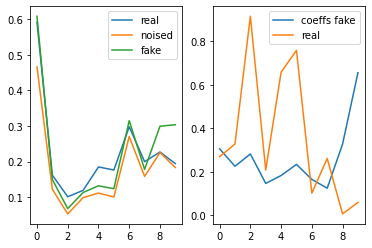

1/1 - 0s - g_loss: 2.0482 - d_loss: 0.6231 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1370
Epoch 202/3000
1/1 - 0s - g_loss: 2.1346 - d_loss: 0.6059 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1358
Epoch 203/3000
1/1 - 0s - g_loss: 2.3078 - d_loss: 0.6302 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1344
Epoch 204/3000
1/1 - 0s - g_loss: 2.1321 - d_loss: 0.5980 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1328
Epoch 205/3000
1/1 - 0s - g_loss: 2.1813 - d_loss: 0.5940 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1311
Epoch 206/3000
1/1 - 0s - g_loss: 2.3539 - d_loss: 0.6068 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1293
Epoch 207/3000
1/1 - 0s - g_loss: 2.2610 - d_loss: 0.5827 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1273
Epoch 208/3000
1/1 - 0s - g_loss: 2.1513 - d_loss: 0.5850 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

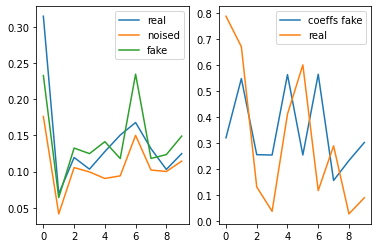

1/1 - 0s - g_loss: 2.9890 - d_loss: 0.4237 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1460
Epoch 252/3000
1/1 - 0s - g_loss: 3.0006 - d_loss: 0.4188 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1459
Epoch 253/3000
1/1 - 0s - g_loss: 3.0364 - d_loss: 0.4142 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1457
Epoch 254/3000
1/1 - 0s - g_loss: 3.1127 - d_loss: 0.4101 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1451
Epoch 255/3000
1/1 - 0s - g_loss: 3.0514 - d_loss: 0.4047 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1445
Epoch 256/3000
1/1 - 0s - g_loss: 3.2350 - d_loss: 0.3993 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1435
Epoch 257/3000
1/1 - 0s - g_loss: 3.0233 - d_loss: 0.4122 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1425
Epoch 258/3000
1/1 - 0s - g_loss: 3.2072 - d_loss: 0.4036 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

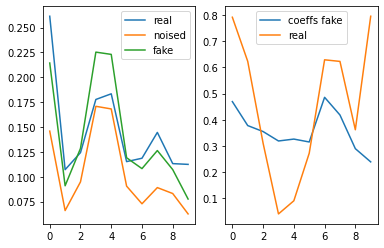

1/1 - 0s - g_loss: 3.4353 - d_loss: 0.3454 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0731
Epoch 302/3000
1/1 - 0s - g_loss: 3.1458 - d_loss: 0.3574 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0735
Epoch 303/3000
1/1 - 0s - g_loss: 3.5423 - d_loss: 0.3616 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0740
Epoch 304/3000
1/1 - 0s - g_loss: 3.3375 - d_loss: 0.3537 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0743
Epoch 305/3000
1/1 - 0s - g_loss: 3.2818 - d_loss: 0.3477 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0746
Epoch 306/3000
1/1 - 0s - g_loss: 3.6287 - d_loss: 0.3577 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0748
Epoch 307/3000
1/1 - 0s - g_loss: 3.4032 - d_loss: 0.3366 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0751
Epoch 308/3000
1/1 - 0s - g_loss: 3.2244 - d_loss: 0.3487 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

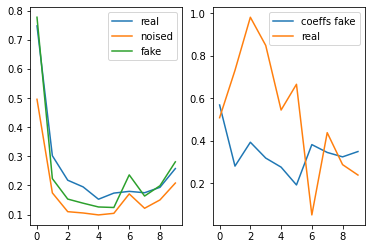

1/1 - 0s - g_loss: 1.9200 - d_loss: 0.6809 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0876
Epoch 352/3000
1/1 - 0s - g_loss: 2.5567 - d_loss: 0.8570 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0902
Epoch 353/3000
1/1 - 0s - g_loss: 1.5998 - d_loss: 0.6779 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0931
Epoch 354/3000
1/1 - 0s - g_loss: 2.2651 - d_loss: 0.5581 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0926
Epoch 355/3000
1/1 - 0s - g_loss: 3.2405 - d_loss: 0.8414 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0896
Epoch 356/3000
1/1 - 0s - g_loss: 1.9680 - d_loss: 0.6119 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0861
Epoch 357/3000
1/1 - 0s - g_loss: 2.2004 - d_loss: 0.5569 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0847
Epoch 358/3000
1/1 - 0s - g_loss: 3.0924 - d_loss: 0.6311 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

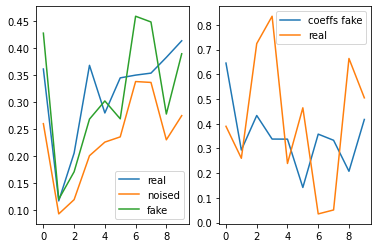

1/1 - 0s - g_loss: 3.4208 - d_loss: 0.4073 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1118
Epoch 402/3000
1/1 - 0s - g_loss: 3.8458 - d_loss: 0.3489 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1106
Epoch 403/3000
1/1 - 0s - g_loss: 4.3183 - d_loss: 0.3570 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1085
Epoch 404/3000
1/1 - 0s - g_loss: 4.3072 - d_loss: 0.4308 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1055
Epoch 405/3000
1/1 - 0s - g_loss: 3.2472 - d_loss: 0.4156 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1000
Epoch 406/3000
1/1 - 0s - g_loss: 2.2238 - d_loss: 0.5234 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0959
Epoch 407/3000
1/1 - 0s - g_loss: 2.3043 - d_loss: 0.5550 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0926
Epoch 408/3000
1/1 - 0s - g_loss: 3.0229 - d_loss: 0.6034 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

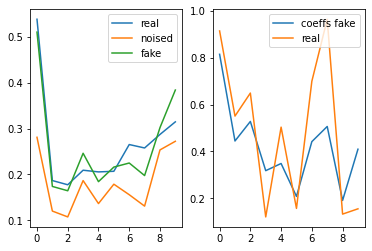

1/1 - 0s - g_loss: 3.4913 - d_loss: 0.3450 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1071
Epoch 452/3000
1/1 - 0s - g_loss: 3.5706 - d_loss: 0.3417 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1079
Epoch 453/3000
1/1 - 0s - g_loss: 3.3158 - d_loss: 0.3395 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1085
Epoch 454/3000
1/1 - 0s - g_loss: 3.3746 - d_loss: 0.3312 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1091
Epoch 455/3000
1/1 - 0s - g_loss: 3.4042 - d_loss: 0.3375 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1090
Epoch 456/3000
1/1 - 0s - g_loss: 3.3204 - d_loss: 0.3384 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1095
Epoch 457/3000
1/1 - 0s - g_loss: 3.2468 - d_loss: 0.3323 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1104
Epoch 458/3000
1/1 - 0s - g_loss: 3.3645 - d_loss: 0.3313 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

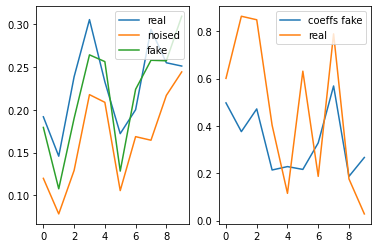

1/1 - 0s - g_loss: 3.7870 - d_loss: 0.3117 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1207
Epoch 502/3000
1/1 - 0s - g_loss: 3.6731 - d_loss: 0.2910 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1211
Epoch 503/3000
1/1 - 0s - g_loss: 3.8610 - d_loss: 0.3011 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1212
Epoch 504/3000
1/1 - 0s - g_loss: 4.0255 - d_loss: 0.2801 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1207
Epoch 505/3000
1/1 - 0s - g_loss: 4.0864 - d_loss: 0.2935 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1211
Epoch 506/3000
1/1 - 0s - g_loss: 4.0867 - d_loss: 0.2842 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1207
Epoch 507/3000
1/1 - 0s - g_loss: 3.8508 - d_loss: 0.2886 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1205
Epoch 508/3000
1/1 - 0s - g_loss: 3.9683 - d_loss: 0.2843 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

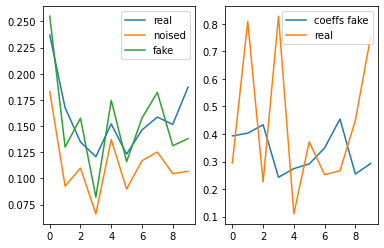

1/1 - 0s - g_loss: 4.6652 - d_loss: 0.2526 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1058
Epoch 552/3000
1/1 - 0s - g_loss: 4.2296 - d_loss: 0.2700 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1052
Epoch 553/3000
1/1 - 0s - g_loss: 4.2531 - d_loss: 0.2631 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1051
Epoch 554/3000
1/1 - 0s - g_loss: 4.6507 - d_loss: 0.2537 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1047
Epoch 555/3000
1/1 - 0s - g_loss: 4.6994 - d_loss: 0.2595 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1046
Epoch 556/3000
1/1 - 0s - g_loss: 4.4360 - d_loss: 0.2665 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1039
Epoch 557/3000
1/1 - 0s - g_loss: 4.2503 - d_loss: 0.2553 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.1033
Epoch 558/3000
1/1 - 0s - g_loss: 4.4905 - d_loss: 0.2653 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

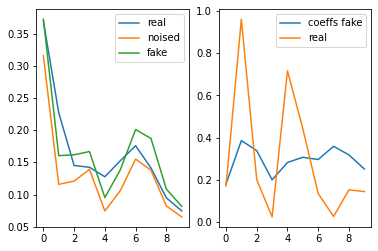

1/1 - 0s - g_loss: 4.9480 - d_loss: 0.2154 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0928
Epoch 602/3000
1/1 - 0s - g_loss: 4.9063 - d_loss: 0.2207 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0931
Epoch 603/3000
1/1 - 0s - g_loss: 5.0488 - d_loss: 0.2124 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0928
Epoch 604/3000
1/1 - 0s - g_loss: 5.2940 - d_loss: 0.2012 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0926
Epoch 605/3000
1/1 - 0s - g_loss: 5.2369 - d_loss: 0.2220 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0918
Epoch 606/3000
1/1 - 0s - g_loss: 5.0018 - d_loss: 0.2229 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0921
Epoch 607/3000
1/1 - 0s - g_loss: 5.0103 - d_loss: 0.2092 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_diversity: 0.0920
Epoch 608/3000
1/1 - 0s - g_loss: 5.4238 - d_loss: 0.2290 - diff_with_real: 3.7533e-04 - noise: 3.7533e-04 - g_d

In [ ]:
#!g2.mig
%matplotlib inline

# Данные в генератор и дискриминатор передавать как stft * linear_to_mel_weight_matrix
# Для эквалайзера использовать updated_linear_to_mel_weight_matrix

# stft shape (7994, 1025, 41)
# bands shape (7994, 10, 41)
@register("model")
@inject("bands", "keras", "tf", "plt", log=True)
def getModel():
    # bands -> eq_coeffs
    generator =  tf.keras.Sequential([
#         Input((10, 41)),
        Input((2, 10, 1)),
        Flatten(),
#         Dense(50, activation="relu"),
#         Dense(820, activation="tanh"),
#         Dense(50, activation="tanh"),
#         Dense(50, activation="tanh"),
        
        Dense(20, activation="tanh"),
        Dense(20, activation="tanh"),

        Dense(10, activation="sigmoid")
    ])
    
    # bands -> false/true
    discriminator = tf.keras.Sequential([
#         Input((10, 41)),
        Input((2, 10, 1)),
        Flatten(),
#         Dense(820, activation="tanh"),
#         Dense(50, activation="tanh"),
        Dense(20, activation="relu"),
        Dense(20, activation="relu"),
        
#         Dense(50, activation="tanh"),
        
        Dense(1)
    ])
    
    
    BATCH_SIZE = 7993
    dataset = tf.data.Dataset.from_tensor_slices((bands[:, :, 0:1], ))
    dataset = dataset.shuffle(buffer_size=60000).batch(BATCH_SIZE, drop_remainder=True)
    

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    class GAN(keras.Model):
        def __init__(self, discriminator, generator):
            super(GAN, self).__init__()
            self.discriminator = discriminator
            self.generator = generator
            self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
            self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
            self.diff_with_real_tracker = keras.metrics.Accuracy(name="diff_with_real")
            self.noise_tracker = keras.metrics.Accuracy(name="noise")
            self.g_diversity_tracker = keras.metrics.Mean(name="g_diversity")
            
            self.last_g_loss = 1
            self.last_d_loss = 1
            self.show_asdf = False

        @property
        def metrics(self):
            return [self.gen_loss_tracker, self.disc_loss_tracker, self.diff_with_real_tracker, self.noise_tracker, self.g_diversity_tracker]

        def compile(self, d_optimizer, g_optimizer, *args, **kwargs):
            super(GAN, self).compile(*args, **kwargs)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer

        def train_step(self, dataset):
#             BATCH_SIZE = 1024
#             real_bands_indicies = np.random.choice(bands_dataset.shape[0], BATCH_SIZE, replace=False)
#             real_bands = bands[real_bands_indicies]
            real_bands = dataset[0]
#             random_eq_coeffs = np.array([1, 1, 0.3, 1, 1, 1, 1, 1, 1, 1])
#             random_eq_coeffs = np.repeat(random_eq_coeffs[np.newaxis, ...], BATCH_SIZE, axis=0)
            random_eq_coeffs = np.random.uniform(0.5, 1, (BATCH_SIZE, 10))

#             real_bands_with_noise = apply_eq_to_bands(real_bands, random_eq_coeffs)
            random_eq_coeffs_tensor = tf.constant(random_eq_coeffs[..., np.newaxis], dtype=tf.float32)
            real_bands_with_noise = tf.multiply(real_bands, random_eq_coeffs_tensor)
        
        
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#                 eq_coeffs_generated = generator(real_bands_with_noise, training=True)
                eq_coeffs_generated = generator(tf.stack([real_bands, real_bands_with_noise], axis=1), training=True)
#                 eq_coeffs_generated = tf.clip_by_value(eq_coeffs_generated, -0.5, 0.5)
                
#                 fake_bands = apply_eq_to_bands(real_bands_with_noise, eq_coeffs_generated)
                fake_bands = real_bands_with_noise * (eq_coeffs_generated[..., tf.newaxis] + 1)

#                 real_output = discriminator(real_bands, training=True)
#                 fake_output = discriminator(fake_bands, training=True)

                real_output = discriminator(tf.stack([real_bands, real_bands], axis=1), training=True)
                fake_output = discriminator(tf.stack([fake_bands, real_bands], axis=1), training=True)

                gen_loss = generator_loss(fake_output)
#                 gen_loss = tf.keras.losses.MeanSquaredError()(real_bands, fake_bands) #generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            if self.last_g_loss > 0.3 or True:
                gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
                self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            
            if self.last_d_loss > 0.3 or True:
                gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
                self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            
            if self.show_asdf:
                fig, (ax1, ax2) = plt.subplots(1, 2)
                ax1.plot(real_bands[0, :, 0], label="real")
                ax1.plot(real_bands_with_noise[0, :, 0], label="noised")
                ax1.plot(fake_bands[0, :, 0], label="fake")
                ax1.legend()
                ax2.plot(eq_coeffs_generated[0, :], label="coeffs fake")
                ax2.plot((1 / random_eq_coeffs[0, :]) - 1, label="real")
                ax2.legend()
                fig.show()
                
                plt.show()

            self.gen_loss_tracker.update_state(gen_loss)
            self.disc_loss_tracker.update_state(disc_loss)
            self.diff_with_real_tracker.update_state(real_bands, fake_bands)
            self.noise_tracker.update_state(real_bands, real_bands_with_noise)
#             self.g_diversity_tracker.update_state(np.mean(eq_coeffs_generated))
            self.g_diversity_tracker.update_state(tf.math.reduce_std(eq_coeffs_generated))
            
            return {
                "g_loss": self.gen_loss_tracker.result(), 
                "d_loss": self.disc_loss_tracker.result(),
                "diff_with_real": self.diff_with_real_tracker.result(),
                "noise": self.noise_tracker.result(),
                "g_diversity": self.g_diversity_tracker.result(),
            }
        
    class CustomCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            gan.last_g_loss = logs['g_loss']
            gan.last_d_loss = logs['d_loss']
            if epoch % 50 == 49:
                gan.show_asdf = True
            else:
                gan.show_asdf = False
            
            
    gan = GAN(discriminator, generator)
    gan.compile(
        g_optimizer = tf.keras.optimizers.Adam(1e-3), # 1e-3
        d_optimizer = tf.keras.optimizers.Adam(1e-3 * 5), # 1e-3
        run_eagerly=True
    )
    gan.fit(dataset, epochs=3000, verbose=2, callbacks=[CustomCallback()])
    
    gan.generator.save("generator.keras")
    print("saved")
    
@register("generator")
@inject("keras")
def load_generator():
    return load_model("generator.keras")

run_proc(getModel)


In [13]:
#!g2.mig
@inject("generator", "bands", log=True)
def test():
#     eq_coeffs = generator.predict(bands[0:2, :, :])
    eq_coeffs = generator.predict(np.stack((bands[0:10, :, :], bands[0:10, :, :] * 2), axis=1))
    print(eq_coeffs)
    
run_proc(test)    

starting proc
loading generator


2022-09-18 16:50:30.390026: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 16:50:30.919762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0


loading bands


2022-09-18 16:50:31.164391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-18 16:50:31.802206: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[[-1.         -0.9999867  -1.         -1.         -0.99999905  1.
  -1.          1.         -1.          1.        ]
 [-1.         -0.9999845  -1.         -1.         -0.9999993   1.
  -1.          1.         -1.          1.        ]
 [-1.         -0.9999986  -1.         -1.         -1.          1.
  -1.          1.         -1.          1.        ]
 [-0.93244874 -0.827925   -0.9998771  -0.9813186  -0.8704484   0.99496263
  -0.99085426  0.9924538  -0.99312013  0.9910126 ]
 [-0.9789094  -0.9265134  -0.9999937  -0.9954161  -0.9576255   0.9992423
  -0.9983812   0.99879754 -0.99905986  0.9985699 ]
 [-1.         -1.         -1.         -1.         -1.          1.
  -1.          1.         -1.          1.        ]
 [-1.         -1.         -1.         -1.         -1.          1.
  -1.          1.         -1.          1.        ]
 [-0.99977905 -0.9975082  -1.         -0.9999905  -0.99935395  1.
  -0.9999989   0.9999995  -0.9999997   0.9999993 ]
 [-0.97707945 -0.918807   -0.99999243 -0.99505496

In [ ]:
#!g2.mig


In [9]:
#!g2.mig
a = np.array([[1, 2],
             [3, 4],
             [5, 6]])
a[np.random.choice(a.shape[0], 2, replace=False)]

array([[3, 4],
       [5, 6]])

In [199]:
#!g2.mig


starting proc
1


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [129]:
#!g2.mig

def model_predict_mag(model, mag):
    import numpy as np
    pred_mag_1024 = model.predict(mag[:, :1024, :])
    mag_1025 = np.concatenate((pred_mag_1024, mag[:, 1024:1025, :]), axis=-2)
    return mag_1025

def getAutoencoder():
    class Autoencoder(Model):
        def __init__(self):
            super(Autoencoder, self).__init__()
            
            
            input_shape = (1024, 9)
            self.encoder = tf.keras.Sequential([
                Input(input_shape),
                Conv1D(filters=10, kernel_size=5, activation='tanh', padding="same"),
                MaxPooling1D(pool_size = 2),
                Conv1D(filters=10, kernel_size=5, activation='tanh', padding="same"),
                MaxPooling1D(pool_size = 2),
                Conv1D(filters=10, kernel_size=5, activation='tanh', padding="same"),
                MaxPooling1D(pool_size = 2),
                Conv1D(filters=10, kernel_size=5, activation='tanh', padding="same"),
                MaxPooling1D(pool_size = 2),
                Conv1D(filters=1, kernel_size=5, activation='tanh', padding="same"),
                Dense(16, activation='tanh'),
            ])
            self.decoder = tf.keras.Sequential([
                Conv1D(filters=10, kernel_size=5, activation='tanh', padding="same"),
                UpSampling1D(size=2),
                Conv1D(filters=10, kernel_size=5, activation='tanh', padding="same"),
                UpSampling1D(size=2),
                Conv1D(filters=10, kernel_size=5, activation='tanh', padding="same"),
                UpSampling1D(size=2),
                Conv1D(filters=10, kernel_size=5, activation='tanh', padding="same"),
                UpSampling1D(size=2),
                Conv1D(filters=10, kernel_size=5, activation='tanh', padding="same"),
                Conv1D(filters=9, kernel_size=5, activation='tanh', padding="same"),
                Reshape( (1024, 9) ),
            ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded
        
        def save(self):
            self.encoder.save('encoder.keras')
            self.decoder.save('decoder.keras')
            
        def load(self):
            self.encoder = load_model("encoder.keras")
            self.decoder = load_model("decoder.keras")
        
    return Autoencoder


def run():
    import numpy as np
    print("loading_data")
    mag_ang = get_ddata(get_x_stft(load_x()))
    print("importing")
    from keras import Model
    from keras.models import Sequential
    # from kapre import InverseSTFT, STFT, Magnitude, MagnitudeToDecibel
    # from kapre.composed import get_melspectrogram_layer, get_log_frequency_spectrogram_layer
    from keras.backend import cast as Cast
    from tensorflow.keras.optimizers import Adam
    import tensorflow as tf
    print("preparing")

    

    
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(mag_ang)
    
# #     model.add(Flatten())
# #     model.add(BatchNormalization())
# #     model.add(Dense(1025 * 1, activation='sigmoid'))


    autoencoder = getAutoencoder()()
    #learning_rate=0.05 learning_rate=0.001 binary_crossentropy
    autoencoder.compile(Adam(), 'mean_squared_error', 'mean_absolute_error')

    print("training")
    import datetime
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    #
    def my_callback(*args, **kwargs):
        import numpy as np
        m1, a1 = np.dsplit(model.predict(mag_ang[:1, :, :]), 2)
        m2, a2 = np.dsplit(mag_ang[:1, :, :], 2)
        import matplotlib.pyplot as plt
        plt.plot(m1.reshape(1025)[:100])
        plt.plot(m2.reshape(1025)[:100])
        plt.show()
        
    def my_callback2(*args, **kwargs):
        import numpy as np
        m1 = model_predict_mag(autoencoder, mag_ang[:1, :, :])
        m2 = mag_ang[:1, :, :]
        import matplotlib.pyplot as plt
        plt.plot(m1[:, :, 0].reshape(1025)[:100])
        plt.plot(m2[:, :, 0].reshape(1025)[:100])
        plt.show()
        
    def scheduler(epoch):
        if epoch % 5 == 4:
            autoencoder.save()
        if epoch < 30:
            return 0.001
        elif epoch < 100:
            return 0.0005
        else:
            return 0.0001
        
    autoencoder.fit(mag_ang[:50, :1024, :], mag_ang[:50, :1024, :], epochs=600, 
            callbacks=[tensorboard_callback, tf.keras.callbacks.LambdaCallback(on_epoch_end=my_callback2),
                       tf.keras.callbacks.LearningRateScheduler(scheduler)], validation_split=0.2)
    autoencoder.save()
    
    
def run_proc(task):
    import multiprocessing
    print("starting proc")
    p = multiprocessing.Process(target=task)
    try:
        p.start()
        p.join()
    except KeyboardInterrupt:
        print("terminating proccess")
        p.terminate()
        from time import sleep
        sleep(1)
        print("killing")
        p.kill()
    
# run_proc(run)

In [ ]:
#!g2.mig


In [156]:
import inspect
registered_functions = {}


def register(name):
    def decorator(fn):
        def wrapper():
            res = fn()
            return {
                name : res
            }
        
        registered_functions[name] = wrapper
        return fn
    return decorator


def register_dict(name):
    def decorator(fn):
        def wrapper():
            res = fn()
            return res
        
        registered_functions[name] = wrapper
        return fn
    return decorator
    

def inject(*names):
    def decorator(fn):
        from functools import wraps
        @wraps(fn)
        def wrapper(*args, **kwargs):
            backup = {}
            for name in names:
                if name not in registered_functions:
                    raise Exception("Not found " + str(name) + " in registered functions. " + str(registered_functions.keys()))
                    
                function_result = registered_functions[name]()
                    
                for var_name in function_result:
                    if var_name in fn.__globals__:
                        backup[var_name] = fn.__globals__[var_name]
                    fn.__globals__[var_name] = function_result[var_name]
            
            res = fn(*args, **kwargs)
            
            for name in backup:
                fn.__globals__[name] = backup[name]
            
            return res
            
        return wrapper
    return decorator


@register_dict("mnp")
def import_mnp():
    import matplotlib.pyplot as plt
    import numpy as np
    return locals()



[[0. 0.]
 [0. 0.]]
<module 'matplotlib.pyplot' from '/kernel/lib/python3.8/site-packages/matplotlib/pyplot.py'>


In [ ]:
#!g2.mig


In [132]:
#!g2.mig


In [136]:
#!g2.mig
def run():
    import numpy as np
    print("reading and calculating stft")
    mag_ang = nnorm(get_x_stft(load_x()))
    mag, ang = np.dsplit(mag_ang, 2)
    
    print("preparing y")
    import pandas as pd
    y = load_y()
    df = pd.DataFrame(data={'col1': y})
    y_cat = pd.get_dummies(df['col1']).to_numpy()
    
    print("proccessing")
    mag_encoded = mag[:, :1024, :]
    
    from keras.layers import Conv2D, Conv1D, BatchNormalization, ReLU, MaxPooling1D, MaxPooling2D, UpSampling1D, Dense, Softmax, Reshape, Flatten, Input, Dropout
    import tensorflow as tf
    from tensorflow.keras.optimizers import Adam
    
    def conv(filters_cnt):
        return [
            Conv2D(filters=10, kernel_size=3, activation='tanh', padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size = (2, 1)),
        ]
    
    model = tf.keras.Sequential([
               Input((1024, 9)),
               Reshape((1024, 9, 1))
            ] +
            conv(10) +
            conv(10) +
            conv(10) +
            conv(10) +
        
            [
                Flatten(),
                Dense(512, activation='relu'),
                Dropout(0.6),
                BatchNormalization(),
        
                Dense(512, activation='relu'),
                Dropout(0.6),
                BatchNormalization(),
        
                Dense(512, activation='relu'),
                Dropout(0.6),
                BatchNormalization(),
        
                Dense(8, activation='softmax'),
            ])
#     model = tf.keras.Sequential([
#             Input((64, 16)),
#             Flatten(),
#             Dense(256, activation='tanh'),
#             Dense(256, activation='sigmoid'),
#             Dense(256, activation='relu'),
#             Dense(8, activation='softmax'),
#         ])
    
    def scheduler(epoch):
        if epoch % 5 == 4:
            model.save("model.keras")
        return 0.001
        if epoch < 30:
            return 0.001
        elif epoch < 100:
            return 0.0005
        else:
            return 0.0001
    print(mag_encoded.shape, y_cat.shape)
    model.compile(Adam(), 'categorical_crossentropy', 'categorical_accuracy')
    model.fit(mag_encoded, y_cat, epochs=100, 
            callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)], validation_split=0.2, verbose=2)

run_proc(run)

starting proc
reading and calculating stft
preparing y
proccessing
(7996, 1024, 9) (7996, 8)
Epoch 1/100
200/200 - 6s - loss: 2.5374 - categorical_accuracy: 0.1574 - val_loss: 2.0130 - val_categorical_accuracy: 0.1813
Epoch 2/100
200/200 - 2s - loss: 2.2512 - categorical_accuracy: 0.1812 - val_loss: 2.0684 - val_categorical_accuracy: 0.1863
Epoch 3/100
200/200 - 2s - loss: 2.1057 - categorical_accuracy: 0.2009 - val_loss: 1.8541 - val_categorical_accuracy: 0.2800
Epoch 4/100
200/200 - 2s - loss: 2.0105 - categorical_accuracy: 0.2190 - val_loss: 1.8575 - val_categorical_accuracy: 0.3269
Epoch 5/100
200/200 - 3s - loss: 1.9374 - categorical_accuracy: 0.2583 - val_loss: 2.0022 - val_categorical_accuracy: 0.1912
Epoch 6/100
200/200 - 2s - loss: 1.8873 - categorical_accuracy: 0.2724 - val_loss: 1.9825 - val_categorical_accuracy: 0.2850
Epoch 7/100
200/200 - 2s - loss: 1.8606 - categorical_accuracy: 0.2913 - val_loss: 1.7586 - val_categorical_accuracy: 0.3162
Epoch 8/100
200/200 - 2s - loss:

2022-09-16 22:35:41.784704: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 22:35:42.199291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0
2022-09-16 22:35:42.675565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-16 22:35:44.247083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-09-16 22:35:45.507406: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multipli

In [35]:
#!g2.mig
def test():
    import numpy as np
    print("processing x")
    mag_ang = nnorm(get_x_stft(np.load("x.npy")))
    mag, ang = np.dsplit(mag_ang, 2)
    
    print("  autoencoder")
    autoencoder = getAutoencoder()()
    autoencoder.load()
    autoencoder.encoder.compile()
    mag_encoded = autoencoder.encoder.predict(mag[:, :1024, :])
    
    print("processing y")
    import pandas as pd
    y = np.load("y.npy")
    df = pd.DataFrame(data={'col1': y})
    y_cat = pd.get_dummies(df['col1']).to_numpy()
    
    print("load model")
    from keras.models import load_model
    model = load_model("model.keras")
    
    print("confusion matrix")
    y_pred = model.predict(mag_encoded)
    from sklearn.metrics import confusion_matrix
    print(y_pred.shape)
    print(y_pred[:3])
    print(confusion_matrix(y_cat.argmax(axis=1), y_pred.argmax(axis=1)))

run_proc(test)

starting proc
processing x
  autoencoder
processing y
load model
confusion matrix
(7996, 8)
[[0.11667339 0.14175113 0.11960492 0.12665664 0.12259732 0.12679233
  0.13212846 0.11379588]
 [0.14226915 0.12479449 0.08894964 0.17497246 0.10102151 0.1280257
  0.1292968  0.11067025]
 [0.09513927 0.13377663 0.10467512 0.09310499 0.0640965  0.1157955
  0.12832224 0.26508972]]
[[  0 230  34 514  61  30   0 130]
 [  1 345  98 122 162 130   0 141]
 [  0 169 390  48 177 118   0  98]
 [  1 151  10 560  14  53   0 210]
 [  1 285 153  83 347  79   0  52]
 [  0 237  91 163  70 300   0 139]
 [  0 269  84 225  61 108   0 253]
 [  0 138  68 174  32  47   0 540]]


2022-09-16 16:26:34.905193: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 16:26:35.334946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0
2022-09-16 16:26:36.054330: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-16 16:26:36.743816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-09-16 16:26:37.933607: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multipli

In [ ]:
#!g2.mig


In [ ]:
#!g2.mig
#!g2.mig
def run():
    import numpy as np
    print("loading autoencoder")
    autoencoder = getAutoencoder()()
    autoencoder.load()
    autoencoder.encoder.compile()
    print("reading and calculating stft")
    mag_ang = nnorm(get_x_stft(np.load("x.npy")))
    mag, ang = np.dsplit(mag_ang, 2)
    
    print("preparing y")
    import pandas as pd
    y = np.load("y.npy")
    df = pd.DataFrame(data={'col1': y})
    y_cat = pd.get_dummies(df['col1']).to_numpy()
    
    print("proccessing")
    mag_encoded = autoencoder.encoder.predict(mag[:, :1024, :])
    print(mag_encoded.shape)
    
    from keras.layers import Conv2D, Conv1D, BatchNormalization, ReLU, MaxPooling1D, UpSampling1D, Dense, Softmax, Reshape, Flatten, Input, Dropout
    import tensorflow as tf
    from tensorflow.keras.optimizers import Adam
    
    model = tf.keras.Sequential([
                Input((64, 16)),
                Flatten(),
                Dense(512, activation='tanh'),
                Dropout(0.8),
                Dense(512, activation='sigmoid'),
                Dropout(0.8),
                Dense(512, activation='relu'),
                Dropout(0.5),
                Dense(8, activation='softmax'),
            ])
#     model = tf.keras.Sequential([
#             Input((64, 16)),
#             Flatten(),
#             Dense(256, activation='tanh'),
#             Dense(256, activation='sigmoid'),
#             Dense(256, activation='relu'),
#             Dense(8, activation='softmax'),
#         ])
    
    def scheduler(epoch):
        if epoch % 5 == 4:
            model.save("model.keras")
        return 0.001
        if epoch < 30:
            return 0.001
        elif epoch < 100:
            return 0.0005
        else:
            return 0.0001
    print(mag_encoded.shape, y_cat.shape)
    model.compile(Adam(), 'categorical_crossentropy', 'categorical_accuracy')
    model.fit(mag_encoded, y_cat, epochs=100, 
            callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)], validation_split=0.2, verbose=2)

run_proc(run)

In [21]:
#!g2.mig
def test():
    import numpy as np
    import pandas as pd
    y = np.load("y.npy")
    df = pd.DataFrame(data={'col1': y})
    y_cat = pd.get_dummies(df['col1']).to_numpy()
    return y_cat.sum(axis=0)
test()

array([ 999,  999, 1000,  999, 1000, 1000, 1000,  999], dtype=uint64)

In [21]:
#!g2.mig
import numpy as np
a = np.array([[[1, 100], [2, 200], [2, 300], [4, 123], [5, 1234]], 
              [[5, 12345], [6, 51235], [7, 152], [8, 51235], [123, 42134253]]])
a.shape

(2, 5, 2)

In [25]:
#!g2.mig
np.concatenate((a[:, :3, :], a[:, 3:4, :]), axis=2)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 1

In [4]:
#!g2.mig
1

1

In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig
x_stft[0].shape

In [ ]:
#!g2.mig
np.sum((aaa -bbb))

In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig
mag_ang[0, :, :].shape

In [ ]:
#!g2.mig
mag_ang[0:, :, :].shape

In [ ]:
#!g2.mig
def test():
    from keras.models import load_model
    import numpy as np

    mag_ang = nnorm(get_x_stft(np.load("x.npy")))
    mag, ang = np.dsplit(mag_ang[0:1, :, :], 2)
    ma = np.dstack((mag[:, :, 2], ang[:, :, 2]))
    model = load_model('model.keras')
#     m1, a1 = np.dsplit(model.predict(ma), 2)
    m2, a2 = np.dsplit(ma, 2)
    m1, a1 = model.predict(m2), a2

    np.save("m1,a1,m2,a2", [m1.reshape(1025),a1.reshape(1025),m2.reshape(1025),a2.reshape(1025)])

def run():
    run_proc(test)
    m1,a1,m2,a2 = np.load("m1,a1,m2,a2.npy", allow_pickle=True)
    
    import matplotlib.pyplot as plt
    plt.plot(m1[:100])
    plt.plot(m2[:100])
    plt.show()
    plt.plot(a1[:100])
    plt.plot(a2[:100])
run()

In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [75]:
#!g2.mig


def test():
    global x_stft_pred
    import numpy as np
    model = getAutoencoder()()
    model.load()
    
    x_stft_pred = []
    mag_ang = nnorm(get_x_stft(np.load("x.npy")))[1:2, :, :]
    print(mag_ang.shape)
    mag, ang = np.dsplit(mag_ang, 2)
    for i in range(9):
    #     print(x_stft[0, :, i].shape)
#         a = model.predict(np.dstack([  mag[0, :, i], ang[0, :, i]    ]))
        m1 = np.array([   mag[0, :, i:i+1]   ])
        a = np.dstack([       model_predict_mag(model, m1), ang[0, :, i]    ])
        print(denorm(a).shape)
        x_stft_pred.append(denorm(a).reshape(1025))

    x_stft_pred = np.array(x_stft_pred)
    x_stft_pred = np.swapaxes(x_stft_pred, 0, 1)
    
    np.save("x_stft_pred", x_stft_pred)

run_proc(test)

starting proc
(1, 1025, 18)
(1, 1025, 1)
(1, 1025, 1)
(1, 1025, 1)
(1, 1025, 1)
(1, 1025, 1)
(1, 1025, 1)
(1, 1025, 1)
(1, 1025, 1)
(1, 1025, 1)


2022-09-15 19:43:01.756117: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 19:43:02.210690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0
2022-09-15 19:43:09.671023: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-15 19:43:10.540951: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-09-15 19:43:11.658420: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multipli

In [106]:
#!g2.mig


def test():
    global x_stft_pred
    import numpy as np
    model = getAutoencoder()()
    model.load()
    
    x_stft_pred = []
    mag_ang = nnorm(get_x_stft(np.load("x.npy")))[:10, :, :]
    print(mag_ang.shape)
    mag, ang = np.dsplit(mag_ang, 2)
    
    m1 = mag[:, :, :]
    
    mag_pred = model_predict_mag(model, m1)
    ang_pred = ang[:, :, :]
    
    print(mag_pred.shape, ang_pred.shape)
    
    a = np.dstack((mag_pred, ang_pred))
    print(a.shape)
    x_stft_pred = denorm(a)
    print(x_stft_pred.shape)
#     x_stft_pred = .reshape(1025)

#     x_stft_pred = np.array(x_stft_pred)
#     x_stft_pred = np.swapaxes(x_stft_pred, 0, 1)
    
    np.save("x_stft_pred", x_stft_pred)

run_proc(test)

starting proc
(5, 1025, 18)
(5, 1025, 9) (5, 1025, 9)
(5, 1025, 18)
(5, 1025, 9)


2022-09-15 20:06:53.001103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 20:06:53.522106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0
2022-09-15 20:07:00.892888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-15 20:07:01.792924: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-09-15 20:07:02.925166: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multipli

In [172]:
#!g2.mig
import IPython.display as ipd
import librosa
import numpy as np
SAMPLE_RATE = 4096

ipd.Audio(data=librosa.istft(librosa.stft(np.load("x.npy")[4])), rate=SAMPLE_RATE)

In [116]:
#!g2.mig

ipd.Audio(data=librosa.istft(np.load("x_stft_pred.npy")[4]), rate=SAMPLE_RATE)

In [ ]:
#!g2.mig
plt.plot(np.abs(x_stft[0, :, 0]))
plt.show()
plt.plot(np.abs(x_stft_pred[:, 0]))

In [ ]:
#!g2.mig
import matplotlib.pyplot as plt

plt.plot(librosa.istft(librosa.stft(x[0])))
plt.plot(librosa.istft(x_stft_pred))


In [ ]:
#!g2.mig
librosa.istft(x_stft[0])

In [ ]:
#!g2.mig
librosa.istft(x_stft[0])

In [ ]:
#!g2.mig
librosa.istft(x_stft_pred)

In [ ]:
#!g2.mig
x_stft[0].shape

In [ ]:
#!g2.mig
x_stft_pred.shape

In [ ]:
#!g2.mig


In [ ]:
#!g2.mig
!nvidia-smi

In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig


In [ ]:
#!g2.mig
